# Version 3

In This Version the main focus will be to try out different architectures and see if we can improve the accuracy.

I'll also be making the code more modular and will improve the intigration with helper functions.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

from functools import partial

In [2]:
cuda_available = torch.cuda.is_available()
mps_available = torch.backends.mps.is_available()

device = torch.device("cpu")                # For CPU The Default Device
if cuda_available:
    device = torch.device("cuda:0")
elif mps_available:
    device = torch.device("mps")
    
print("Device:", device)

Device: mps


In [3]:
is_local = True
version = 2

PROJECT_PATH =  pathlib.Path(".") / "MNIST-Digit 8k params"

weights_path = PROJECT_PATH / 'weights/version_3'

## Data

### Load MNIST data

In [4]:
train_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=True, 
    download=True,
    transform=transforms.ToTensor()
)
test_data = datasets.MNIST(
    root=PROJECT_PATH, 
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print("Length of train data: ", len(train_data))
print("Length of test data: ", len(test_data))

Length of train data:  60000
Length of test data:  10000


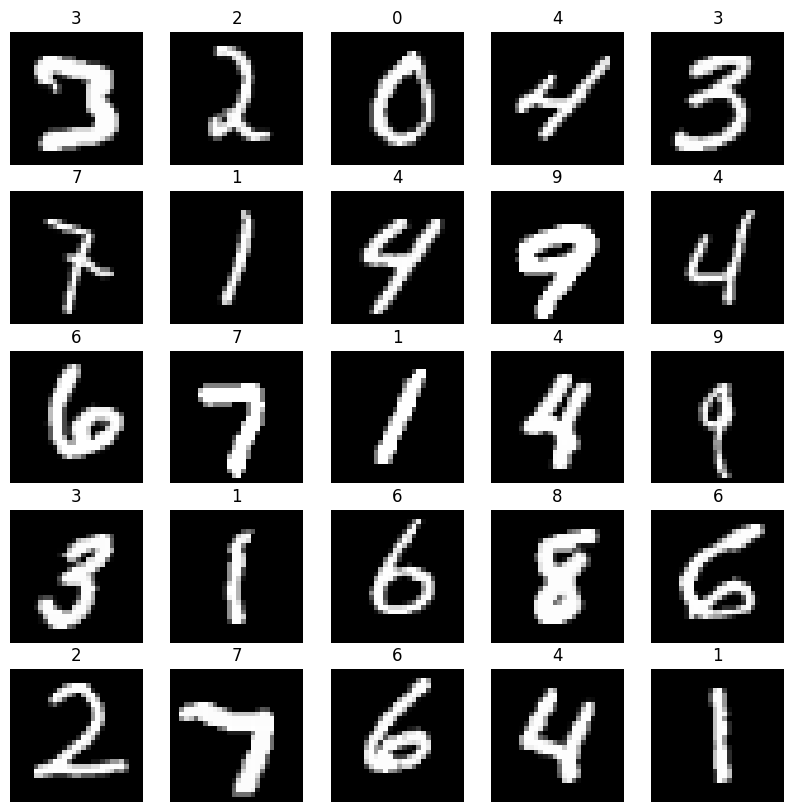

In [5]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=64, shuffle=False)

## MODEL

### Networks

Let's initalize the base class for the network and Block class for the layers. Since I'll be experimenting with different architectures, This will reduce the amount of code I have to write.

In [27]:
# Learning from previous version, we'll be using the following:
# 1. BatchNorm2d
# 2. LeakyReLU (after BN)
class ConvBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
    ):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
            
        return x
        

class DepthwiseConvBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
    ):
        super().__init__()
        self.depth_wise_conv = nn.Conv2d(in_channels, in_channels, kernel_size, groups=in_channels)
        self.point_wise_conv = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.lrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.depth_wise_conv(x)
        x = self.point_wise_conv(x)
        x = self.bn(x)
        x = self.lrelu(x)
            
        return x

class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def forward(self, x):
        raise NotImplementedError
    
    def summary(self, verbose: int=1, **kwargs):
        """
        Prints the summary of the model.
        """
        # Num params
        num_params = sum([np.prod(p.size()) for p in self.parameters()])
        print(f"Number of parameters: {num_params}")
        summary(
            self,
            input_size=(1, 28, 28),
            batch_dim=0,
            col_names = ("input_size", "output_size", "num_params", "kernel_size"),
            verbose = verbose,
            **kwargs
            )


### Training Loop
<!-- I'm going with my useual 1st prefrences
- Adam Optimizer
- Cross Entropy Loss

They often give the best results and are 1st choice for most people. -->

In [28]:
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import copy
import time

def train(
    num_epochs, 
    network, 
    train_loader, 
    val_loader, 
    optimizer, 
    loss_func=None, 
    device="cpu",
    scheduler=None,
    callbacks: dict=None,
):
    if loss_func is None:
        loss_func = nn.CrossEntropyLoss()
    
    network = network.to(device)
    network.train()
    logs = {}
    total_step = len(train_loader)
    print(f"Training on {device} ")
    t_training_start = time.time()
    for epoch in range(1, num_epochs+1):
        t_epoch_start = time.time()
        network.train()
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # forward & back prop
            outputs = network(images)
            
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i == 0:
                print(f"Epoch {epoch}/{num_epochs} (", end="")
                # print(f"Epoch {epoch}/{num_epochs} (lr={optimizer.param_group}) (", end="")
                
            if (i+1) % (total_step//40) == 0:
                print("#", end="")
        
        t = time.time() - t_epoch_start
        # Eveluate
        print(f")\tTime: {t:.2f}s")
        train_loss, train_metrics, _, _ = evaluate(network, train_loader, loss_func, device)
        val_loss, val_metrics, _, _ = evaluate(network, val_loader, loss_func, device)
        print(f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")
        logs[epoch] = {
            "train_loss": train_loss,
            "val_loss": val_loss,
        }
        for metric, value in train_metrics.items():
            logs[epoch][f"train_{metric}"] = value
            logs[epoch][f"val_{metric}"] = val_metrics[metric]
            
            print(f"Train {metric.title()}: {value:.4f} | Val {metric.title()}: {val_metrics[metric]:.4f}")
        
        # Callbacks
        if scheduler:
            scheduler.step()
            
        if callbacks:
            for callback in callbacks:
                callback(
                    epoch=epoch,
                    network=network,
                    logs=logs,
                    train_loss=train_loss,
                    train_metrics=train_metrics,
                    val_loss=val_loss,
                    val_metrics=val_metrics,
                    model=network,
                )
    
        if epoch == 1:
            total_aprox_time = (time.time() - t_epoch_start) * (num_epochs)
            m, s = divmod(total_aprox_time*1.01, 60)
            h, m = divmod(m, 60)
            print(f"--> Approx. time remaining: {h:.0f}h {m:.0f}m {s:.0f}s")
            
            
    total_time = time.time() - t_training_start
    m, s = divmod(total_time, 60)
    h, m = divmod(m, 60)
    print("Finished training")
    print(f"Total time: {h:.0f}h {m:.0f}m {s:.0f}s")
            
    return logs
    

def evaluate(
    network, 
    data_loader, 
    loss_func=None, 
    device="cpu", 
    metrics:list=None
):
    network.eval()
    loss = 0
    original = []
    predicted = []
    
    if loss_func is None:
        loss_func = nn.CrossEntropyLoss()
    if metrics is None:
        metrics = [accuracy_score]
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = network(images)
            loss += loss_func(output, labels).item()

            original += labels.to("cpu").tolist()
            predicted += torch.argmax(output, dim=1).to("cpu").tolist()
    
    metrics = {metric.__name__: metric(original, predicted) for metric in metrics}
    loss = loss / len(data_loader)
    
    return loss, metrics, original, predicted


In [29]:
# All Callbacks
# Logging
def log_model_performance(model_dir, logs, **kwargs):
    logs_df = pd.DataFrame(logs).T
    os.makedirs(model_dir, exist_ok=True)
    log_path = os.path.join(model_dir, 'logs.csv')
    os.remove(log_path) if os.path.exists(log_path) else None
    logs_df.to_csv(log_path)
    
# Checkpoint
def save_model(model_dir, epoch, model,  save_after=1,**kwargs):
    save_path = os.path.join(model_dir, f'model/{epoch}.pt')
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    if epoch % save_after == 0:
        torch.save(model.state_dict(), save_path)

# Early Stopping


In [30]:
# More Functions:
# Plot History
def plot_history(train_accuracy, val_accuracy, train_loss, val_loss):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    # plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    
    print(f"Epochs 5 Validation Accuracy: {val_accuracy[5]*100:.2f}%")
    print(f"Best Validation Accuracy: {max(val_accuracy)*100:.2f}%")
    
    plt.show()
    

### Training 

#### Version 2

Let's Start with Version 2 First and see how the newlly added features work.

In [11]:
from torch import optim

class CNNv2(BaseNetwork):
    def __init__(self):
        super().__init__()
        # Block 1
        self.block1 = nn.Sequential(
            ConvBlock(1, 8),
            ConvBlock(8, 8),
            nn.MaxPool2d(2, 2),
        )
        # Block 2
        self.block2 = nn.Sequential(
            ConvBlock(8, 16),
            ConvBlock(16, 32),
            nn.MaxPool2d(4, 4),
        )
        self.out = nn.Linear(4*32, 10)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

model_name = "Version 2"
cnn_v2 = CNNv2()
cnn_v2.summary()

Number of parameters: 7890
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CNNv2                                    [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 8, 12, 12]            --                        --
│    └─ConvBlock: 2-1                    [1, 1, 28, 28]            [1, 8, 26, 26]            --                        --
│    │    └─Conv2d: 3-1                  [1, 1, 28, 28]            [1, 8, 26, 26]            80                        [3, 3]
│    │    └─BatchNorm2d: 3-2             [1, 8, 26, 26]            [1, 8, 26, 26]            16                        --
│    │    └─LeakyReLU: 3-3               [1, 8, 26, 26]            [1, 8, 26, 26]            --                        --
│    └─ConvBlock: 2-2                    [1, 8, 26, 26]            [1, 8, 24, 24]            --          

In [13]:
model_dir = PROJECT_PATH / "runs" / model_name

callbacks = [
    partial(log_model_performance, model_dir=model_dir),
    partial(save_model, model_dir=model_dir),
]

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_v2.parameters(), lr = 0.004)      # optimizer.param_groups[0]['lr']
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.4)

num_epochs = 6
history = train(
    num_epochs = num_epochs,
    network = cnn_v2,
    train_loader = train_dataloader,
    val_loader = test_dataloader,
    optimizer = optimizer,
    loss_func = loss_func,
    scheduler = scheduler,
    callbacks = callbacks,
    device=device
)

Training on mps 
Epoch 1/6 (########################################)	Time: 14.55s
Train loss: 0.0320 | Val loss: 0.0337
Train Accuracy_Score: 0.9902 | Val Accuracy_Score: 0.9890
--> Approx. time remaining: 0h 2m 1s
Epoch 2/6 (########################################)	Time: 14.02s
Train loss: 0.0207 | Val loss: 0.0278
Train Accuracy_Score: 0.9936 | Val Accuracy_Score: 0.9906
Epoch 3/6 (########################################)	Time: 14.08s
Train loss: 0.0144 | Val loss: 0.0199
Train Accuracy_Score: 0.9958 | Val Accuracy_Score: 0.9934
Epoch 4/6 (########################################)	Time: 14.27s
Train loss: 0.0125 | Val loss: 0.0197
Train Accuracy_Score: 0.9966 | Val Accuracy_Score: 0.9936
Epoch 5/6 (########################################)	Time: 13.78s
Train loss: 0.0118 | Val loss: 0.0191
Train Accuracy_Score: 0.9968 | Val Accuracy_Score: 0.9938
Epoch 6/6 (########################################)	Time: 13.66s
Train loss: 0.0114 | Val loss: 0.0191
Train Accuracy_Score: 0.9972 | V

Epochs 5 Validation Accuracy: 99.38%
Best Validation Accuracy: 99.38%


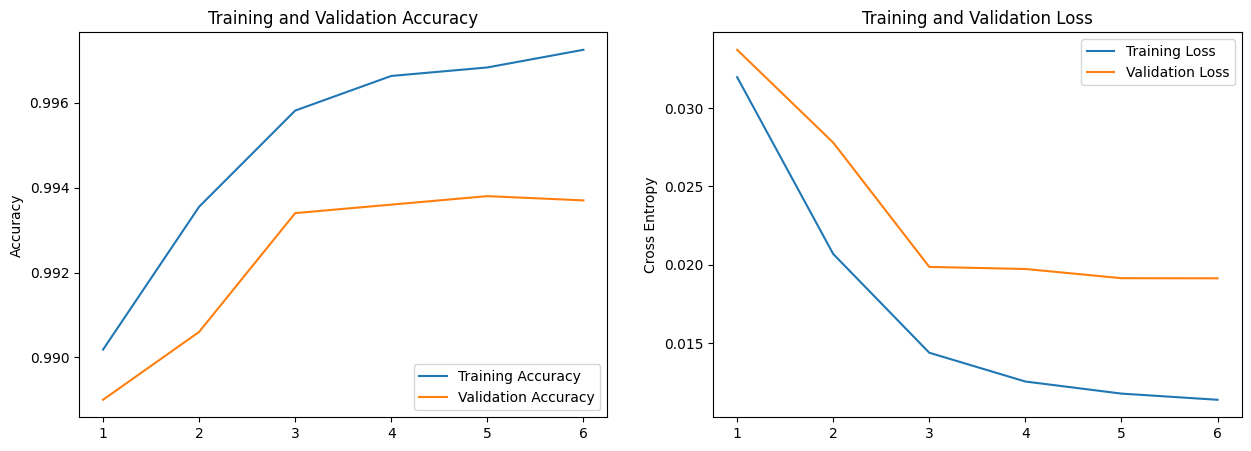

In [15]:
history_df = pd.DataFrame(history).T

plot_history(
    history_df['train_accuracy_score'],
    history_df['val_accuracy_score'],
    history_df['train_loss'],
    history_df['val_loss'],
)

So, The new intigration in the pipeline works. I've added some new features to the pipeline. and the code is more moduelar 

#### Version 2: Mobile
Let's Use the previous model but with Depthwise Separable Convolution


In [31]:
class MobileCNN(BaseNetwork):
    def __init__(self):
        super().__init__()
        # Block 1
        self.block1 = nn.Sequential(
            DepthwiseConvBlock(1, 8),
            DepthwiseConvBlock(8, 8),
            nn.MaxPool2d(2, 2),
        )
        # Block 2
        self.block2 = nn.Sequential(
            DepthwiseConvBlock(8, 16),
            DepthwiseConvBlock(16, 32),
            nn.MaxPool2d(4, 4),
        )
        self.out = nn.Linear(4*32, 10)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

model_name = "Mobile CNN"
mobile_cnn = MobileCNN()
mobile_cnn.summary()

Number of parameters: 2524
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
MobileCNN                                [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                        [1, 1, 28, 28]            [1, 8, 12, 12]            --                        --
│    └─DepthwiseConvBlock: 2-1           [1, 1, 28, 28]            [1, 8, 26, 26]            --                        --
│    │    └─Conv2d: 3-1                  [1, 1, 28, 28]            [1, 1, 26, 26]            10                        [3, 3]
│    │    └─Conv2d: 3-2                  [1, 1, 26, 26]            [1, 8, 26, 26]            16                        [1, 1]
│    │    └─BatchNorm2d: 3-3             [1, 8, 26, 26]            [1, 8, 26, 26]            16                        --
│    │    └─LeakyReLU: 3-4               [1, 8, 26, 26]            [1, 8, 26, 26]            --      

In [33]:
mobile_cnn = MobileCNN()
model_dir = PROJECT_PATH / "runs" / model_name

callbacks = [
    partial(log_model_performance, model_dir=model_dir),
    partial(save_model, model_dir=model_dir),
]

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobile_cnn.parameters(), lr = 0.008)      # optimizer.param_groups[0]['lr']
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma = 0.5)

num_epochs = 10
print(model_name)
history = train(
    num_epochs = num_epochs,
    network = mobile_cnn,
    train_loader = train_dataloader,
    val_loader = test_dataloader,
    optimizer = optimizer,
    loss_func = loss_func,
    scheduler = scheduler,
    callbacks = callbacks,
    device=device,
)

Mobile CNN
Training on mps 
Epoch 1/10 (########################################)	Time: 18.59s
Train loss: 0.0718 | Val loss: 0.0681
Train Accuracy_Score: 0.9777 | Val Accuracy_Score: 0.9764
--> Approx. time remaining: 0h 4m 1s
Epoch 2/10 (########################################)	Time: 18.74s
Train loss: 0.0517 | Val loss: 0.0465
Train Accuracy_Score: 0.9844 | Val Accuracy_Score: 0.9857
Epoch 3/10 (########################################)	Time: 18.26s
Train loss: 0.0320 | Val loss: 0.0328
Train Accuracy_Score: 0.9905 | Val Accuracy_Score: 0.9889
Epoch 4/10 (########################################)	Time: 18.62s
Train loss: 0.0292 | Val loss: 0.0307
Train Accuracy_Score: 0.9915 | Val Accuracy_Score: 0.9896
Epoch 5/10 (########################################)	Time: 18.54s
Train loss: 0.0247 | Val loss: 0.0274
Train Accuracy_Score: 0.9929 | Val Accuracy_Score: 0.9914
Epoch 6/10 (########################################)	Time: 19.03s
Train loss: 0.0240 | Val loss: 0.0260
Train Accuracy_

Epochs 5 Validation Accuracy: 99.14%
Best Validation Accuracy: 99.25%


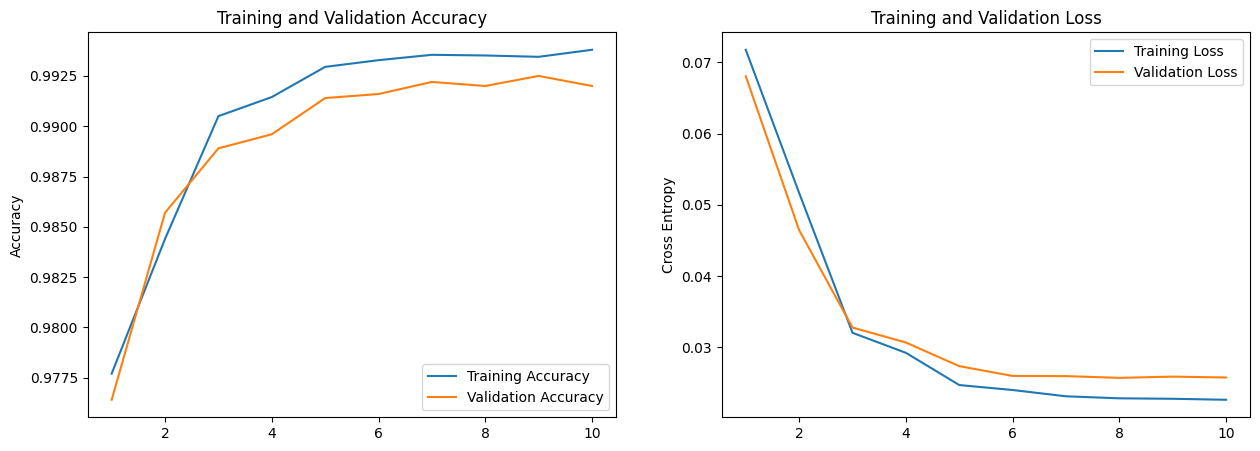

In [34]:
history_df = pd.DataFrame(history).T

plot_history(
    history_df['train_accuracy_score'],
    history_df['val_accuracy_score'],
    history_df['train_loss'],
    history_df['val_loss'],
)